Consider a particle estimate computed at time $t$ of a SMC algorithm: 
$$\mathbb{Q}_t^N(\varphi) = \sum_{n=1}^N W_t^n \varphi(X_t^n).$$

A basic way to evaluate its variability is to run the algorithm many times, and report the empirical variance. Which is of course expensive. (Note however that ``multiSMC`` in the core module makes it possible to run SMC algorithms in parallel on multiple-core machines). 

Several recent papers (Chan and Lai, 2013; Lee and Whiteley, 2018; Olsson and Douc, 2019) have proposed estimators of the variance of a particle estimate that may be computed from a **single run**. These estimators require to track the genealogy of the particle system. In fact, the expression of these estimators is a variation of this: 
$$\sum_{n=1}^N \left[\sum_{m:B_t^m=n} W_t^m \left\{\varphi(X_t^m) - \mathbb{Q}_t^N(\varphi)\right\} \right]^2$$
where $B_t^n$ is the index of the ancestor of $X_t^n$ at time $0$ (the so-called **eve variables** in Lee and Whiteley, 2018). Note that this quantity **equals zero** as soon as all the particles have the same ancestor at time $0$. More generally, we expect these estimators to suffer from TODO.


This notebook explains:

* explains how to compute such estimators, using module ``variance_estimators``;
* showcase their performance in a toy example.

In [16]:
import itertools as it

from matplotlib import pyplot as plt
import numpy as np
from numpy import random
import pandas as pd
from scipy import stats
import seaborn as sb

import particles 
from particles import state_space_models as ssms
from particles import kalman  # Linear Gaussian state space models are defined here

plt.style.use('ggplot')

We consider a basic univariate linear Gaussian model:

\begin{align*}
X_t & = \rho X_{t-1} + \sigma_X U_t \\
Y_t & = X_t + \sigma_Y V_t
\end{align*}
with $\rho=0.9$, $\sigma_X=1$, $\sigma_Y=0.2$. 

Data ($T=25)$ are simulated from the model. 

Let's run a single bootstrap filter, and have a look at the genealogical tree.

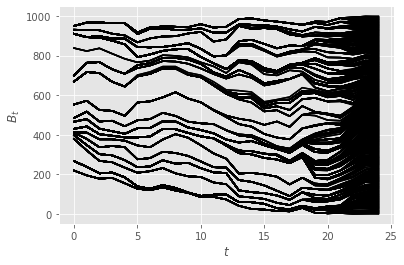

In [2]:
T = 25
ssm = kalman.LinearGauss(rho=0.9, sigmaX=1., sigmaY=0.2)
true_x, data = ssm.simulate(T)
fk = ssms.Bootstrap(ssm=ssm, data=data)
N = 1_000
alg = particles.SMC(fk=fk, N=N, store_history=True) # store_history: keeps the complete history
alg.run()

B = alg.hist.compute_trajectories()

plt.figure()
for n in range(N):
    plt.plot(B[:, n], 'k')
plt.xlabel(r'$t$')
plt.ylabel(r'$B_t$');

The plot above represents the index of the ancestors of the final particles, $X_T^n$, at the previous times. Alternatively, we can plot the number of distinct ancestors (of particles $X_T^n$) at time $t$; see below. Clearly, although this is a toy example, and the number of time steps is quite small, we already observe some strong path degeneracy (although the number of ancestors at time 0 does not collapse to one).  

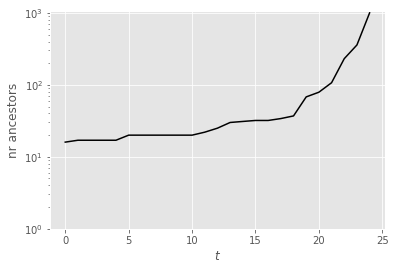

In [3]:
plt.figure()
plt.plot([np.unique(B[t, :]).shape[0] for t in range(T)], 'k')
plt.xlabel(r'$t$')
plt.ylabel('nr ancestors')
plt.ylim(bottom=1)
plt.yscale('log')

In [4]:
def phi(x):
    return x
max_lag = 21
nruns = 10_000
runs = particles.multiSMC(fk=fk, N=N, moments=True, var_est=phi, lag_based_var_est=phi, 
                          norm_cst_var_est=True, store_history=max_lag, nruns=nruns, nprocs=0)

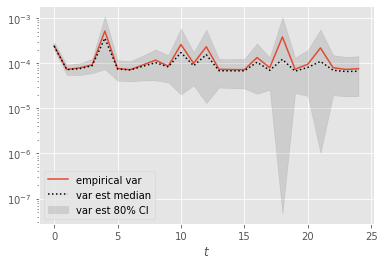

In [5]:
def plot_ci(time_range, arr):
    plt.plot(time_range, np.percentile(arr, 50, axis=0), 'k:', label='var est median')
    plt.fill_between(time_range, np.percentile(arr, 10, axis=0), np.percentile(arr, 90, axis=0), 
                     alpha=0.1, color='black', label='var est 80% CI')


plt.figure()
ests =  np.array([[r['output'].summaries.moments[t]['mean'] for r in runs] for t in range(T)]).T
plt.plot(np.var(ests, axis=0), label='empirical var')
var_ests = np.array([r['output'].summaries.var_est for r in runs])
plot_ci(np.arange(T), var_ests)
plt.legend()
plt.xlabel(r'$t$')
plt.yscale('log')

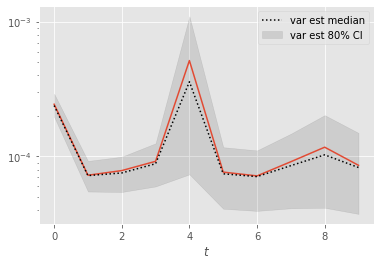

In [6]:
t0 = 10
plt.figure()
plt.plot(np.var(ests[:, :t0], axis=0))
plot_ci(np.arange(t0), var_ests[:, :t0])
plt.legend()
plt.xlabel(r'$t$')
plt.yscale('log')

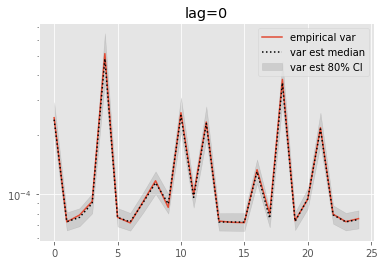

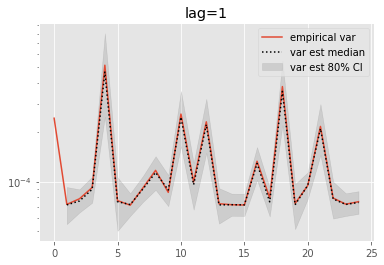

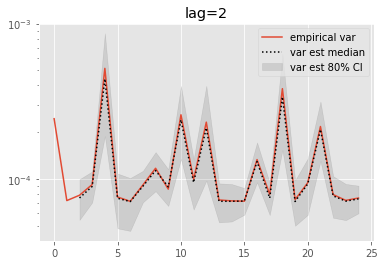

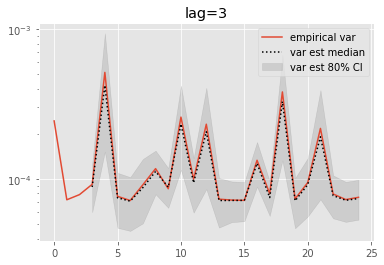

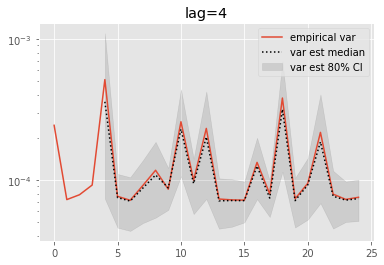

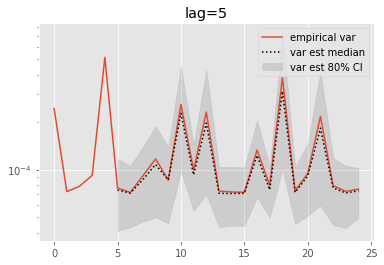

In [7]:
# TODO 
def get_list(l, k):
    if k<len(l):
        return l[k]
    else:
        return 0.
for lag in range(0, 6):
    plt.figure()
    plt.title('lag=%i' % lag)
    plt.plot(np.var(ests, axis=0), label='empirical var')
    times = list(range(lag, T))
    lag_var_ests = np.array([[get_list(est, lag) for est in r['output'].summaries.lag_based_var_est[lag:]] 
                            for r in runs])
    plot_ci(times, lag_var_ests)
    plt.legend()
    plt.yscale('log')

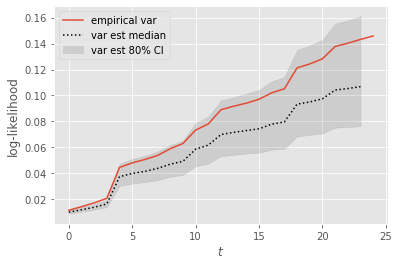

In [8]:
plt.plot([np.var([r['output'].summaries.logLts[t] for r in runs]) for t in range(T)], label='empirical var')
ll_var_ests = np.array([r['output'].summaries.norm_cst_var_est for r in runs])
plot_ci(np.arange(T - 1), ll_var_ests[:, 1:])
plt.xlabel(r'$t$')
plt.ylabel('log-likelihood')
plt.legend()
# NOTE shift by one 

In [ ]:
nsample = 10
nboot = 10_000
boot_emp_var = np.zeros((nboot, T))
boot_var_ests = np.zeros((nboot, T))
for n in range(nboot):
    idx = random.choice(nruns, size=nsample, replace=False)
    boot_emp_var[n, :] = np.var(ests[idx, :], axis=0)
    boot_var_ests[n, :] = np.mean(var_ests[idx, :], axis=0)

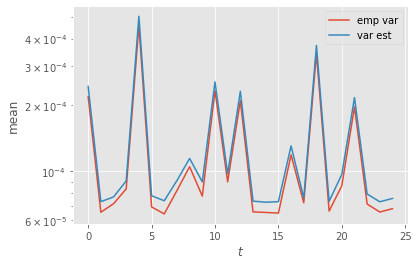

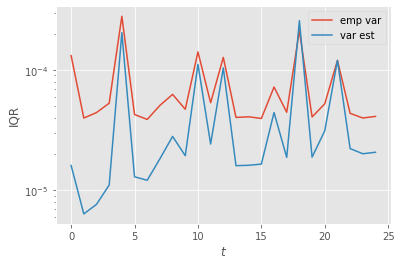

In [22]:
plt.figure()
plt.plot(np.mean(boot_emp_var, axis=0), label='emp var')
plt.plot(np.mean(boot_var_ests, axis=0), label='var est')
plt.xlabel(r'$t$')
plt.ylabel('mean')
plt.yscale('log')
plt.legend();

plt.figure()
plt.plot(stats.iqr(boot_emp_var, axis=0), label='emp var')
plt.plot(stats.iqr(boot_var_ests, axis=0), label='var est')
plt.xlabel(r'$t$')
plt.ylabel('IQR')
plt.yscale('log')
plt.legend();

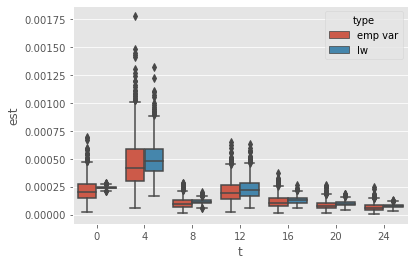

In [14]:
import itertools
d1 = [{'t': t, 'type': 'emp var', 'est': boot_emp_var[n, t]} for n, t in it.product(range(N), range(T))]
d2 = [{'t': t, 'type': 'lw', 'est': boot_var_ests[n, t]} for n, t in it.product(range(N), range(T))]
import pandas 
df = pandas.DataFrame(d1 + d2)
dft = df[df['t'] % 4 == 0 ]
sb.boxplot(x='t', y='est', hue='type', data=dft)